**[MoveNet](https://t.co/QpfnVL0YYI?amp=1)** is an ultra fast and accurate model that detects 17 keypoints of a body. The model is offered on [TF Hub](https://tfhub.dev/s?q=movenet) with two variants, known as Lightning and Thunder. Lightning is intended for latency-critical applications, while Thunder is intended for applications that require high accuracy. Both models run faster than real time (30+ FPS) on most modern desktops, laptops, and phones, which proves crucial for live fitness, health, and wellness applications.


<img src="https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/combined_squat_dance.gif" alt="drawing"/>

*Images downloaded from Pexels (https://www.pexels.com/)

This Colab walks you through the details of how to load MoveNet, and run inference on the input image and video below.

Note: check out the [live demo](https://storage.googleapis.com/tfjs-models/demos/pose-detection/index.html?model=movenet) for how the model works!

# Human Pose Estimation with MoveNet

## Visualization libraries & Imports

In [96]:
#!pip install -q imageio
#!pip install -q opencv-python
#!pip install -q git+https://github.com/tensorflow/docs

In [97]:
#!pip install tensorflow_hub
#!pip install tensorflow_docs

In [98]:
#!pip install opencv-python

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import pandas as pd
import platform

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

2024-07-09 09:19:25.055717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 09:19:25.089614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 09:19:25.089652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 09:19:25.109197: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 09:19:26.377760: W tensorflow/compiler/tf

Helper function for plotting

In [5]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'fuchsia',
    (7, 9): 'fuchsia',
    (6, 8): 'darkcyan',
    (8, 10): 'darkcyan',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

## Load Model from TF hub

Select your movenet model

#@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

In [24]:
model_name = "movenet_thunder" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

In [25]:
if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

## Single Image Example

This session demonstrates the minumum working example of running the model on a **single image** to predict the 17 human keypoints.

First, select the model. Can either be 'movenet_ligthning' or 'movenet_thunder'

In [20]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS🐑🏀/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is 
data directory is ../human_pose_local/archive/Human Action Recognition


### Load Input Image

In [7]:
# Load the input image.

image_path = data_directory + '/train/Image_87.jpg'

image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

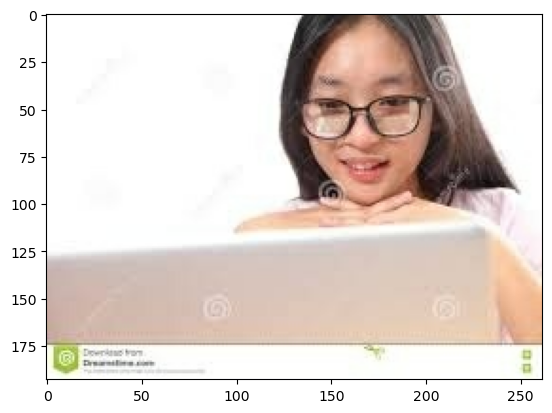

In [8]:
plt.imshow(image)

### Run Inference

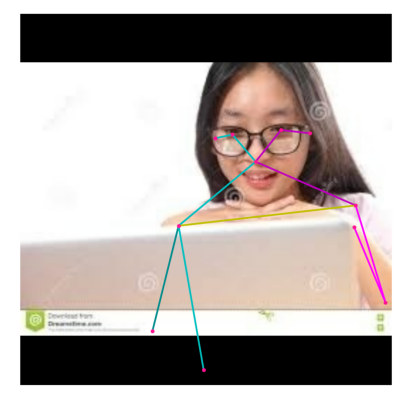

In [29]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [30]:
keypoints_with_scores

array([[[[0.39760366, 0.6337671 , 0.66706026],
         [0.3122344 , 0.7021836 , 0.7853375 ],
         [0.32455456, 0.57122445, 0.73979753],
         [0.32102785, 0.78019136, 0.5093826 ],
         [0.33432594, 0.5252049 , 0.53428614],
         [0.5154087 , 0.90312564, 0.52794164],
         [0.5701569 , 0.42626485, 0.68236715],
         [0.77709544, 0.98363686, 0.35330486],
         [0.8544702 , 0.35563293, 0.15706033],
         [0.5742659 , 0.8992891 , 0.41988182],
         [0.7224712 , 0.46364602, 0.0874453 ],
         [0.8778617 , 0.8007113 , 0.05116187],
         [0.95875365, 0.49381807, 0.18169929],
         [0.6634375 , 0.9432913 , 0.02521384],
         [0.5832754 , 0.40469787, 0.08727323],
         [0.49303803, 0.5764176 , 0.0858596 ],
         [0.64170593, 0.6625846 , 0.00738892]]]], dtype=float32)

(0.0, 1.0)

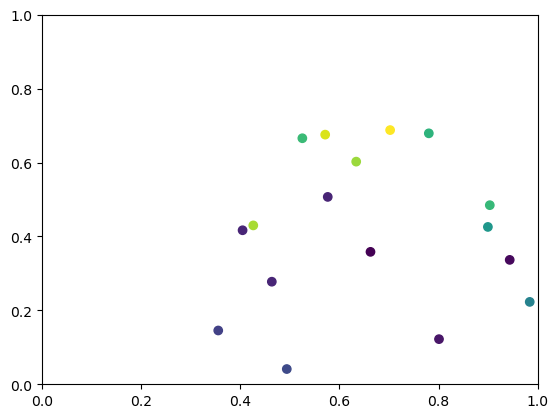

In [31]:
x = keypoints_with_scores.reshape(17,3)[:,1]
y = 1 - keypoints_with_scores.reshape(17,3)[:,0]
color = keypoints_with_scores.reshape(17,3)[:,2]
plt.scatter(x, y, c=color)
plt.xlim(0,1)
plt.ylim(0,1)

## Batch process files

In [32]:
df = pd.read_csv(data_directory+'/Training_set.csv')

In [33]:
# assign number to the label column of the df
df['label'] = df['label'].astype('category')
df['category'] = df['label'].cat.codes
df

,filename,label,category
0,Image_1.jpg,sitting,11
1,Image_2.jpg,using_laptop,14
2,Image_3.jpg,hugging,7
3,Image_4.jpg,sleeping,12
4,Image_5.jpg,using_laptop,14
...,...,...,...
12595,Image_12596.jpg,sitting,11
12596,Image_12597.jpg,clapping,1
12597,Image_12598.jpg,sitting,11
12598,Image_12599.jpg,dancing,3


### Extracting Keypoints from images

In [34]:
# define a function that takes as input the image path and returns the image with the keypoints and the category
def image_keypoints(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)

    return keypoints_with_scores.reshape(17,3)

In [35]:
image_path = data_directory + '/train/Image_87.jpg'
data = image_keypoints(image_path)
data

array([[0.39760366, 0.6337671 , 0.66706026],
       [0.3122344 , 0.7021836 , 0.7853375 ],
       [0.32455456, 0.57122445, 0.73979753],
       [0.32102785, 0.78019136, 0.5093826 ],
       [0.33432594, 0.5252049 , 0.53428614],
       [0.5154087 , 0.90312564, 0.52794164],
       [0.5701569 , 0.42626485, 0.68236715],
       [0.77709544, 0.98363686, 0.35330486],
       [0.8544702 , 0.35563293, 0.15706033],
       [0.5742659 , 0.8992891 , 0.41988182],
       [0.7224712 , 0.46364602, 0.0874453 ],
       [0.8778617 , 0.8007113 , 0.05116187],
       [0.95875365, 0.49381807, 0.18169929],
       [0.6634375 , 0.9432913 , 0.02521384],
       [0.5832754 , 0.40469787, 0.08727323],
       [0.49303803, 0.5764176 , 0.0858596 ],
       [0.64170593, 0.6625846 , 0.00738892]], dtype=float32)

In [36]:
def norm_keypoints(data):
    # Amplitude estimate for each axes
    norm_factor_x = np.percentile(data[:, 0], 95) - np.percentile(data[:, 0], 5)
    norm_factor_y = np.percentile(data[:, 1], 95) - np.percentile(data[:, 1], 5)

    data[:, 0] = (data[:, 0] - np.percentile(data[:, 0], 5)) / norm_factor_x
    data[:, 1] = (data[:, 1] - np.percentile(data[:, 1], 5)) / norm_factor_y

    return data

In [37]:
def get_dataset(df, data_directory):
    
    keypoints_dataset = np.zeros((len(df),17,3))
    
    for i, file in enumerate(df['filename']):
        
        keypoints_dataset[i,:,:] = norm_keypoints(image_keypoints(data_directory + '/train/' + file))
        
    return keypoints_dataset
        

In [38]:
testing_data = get_dataset(df.head(100), data_directory)

testing_labels = df.head(100)['category']

print(testing_data.shape, testing_labels.shape)

(100, 17, 3) (100,)


### Write and load functions

Takes the refernece dataframe for the images as input, computes the keypoints and writes a csv file with structure (img_name, label, keypoints)

In [39]:
def preprocess_data(df, data_directory, model_type = model_name):

    df = df.astype('object')

    df['keypoints'] = np.zeros((len(df),51)).tolist()
    

    # save in the same csv, the name of the file and the keypoints and the labels
    kds = get_dataset(df, data_directory).reshape(-1, 51).tolist()
    df['keypoints'] = kds

    df.to_csv(data_directory + '/preprocessed_train_set_' + model_type + '.csv', index=False)

In [40]:
preprocess_data(df, data_directory)

In [21]:
import ast
def load_data(data_directory, file_name):
    loaded_df = pd.read_csv(data_directory+'/'+file_name)
    loaded_df['keypoints'] = loaded_df['keypoints'].apply(lambda x: np.array(ast.literal_eval(x)).reshape(17,3))
    return loaded_df

In [13]:
file_name = 'preprocessed_train_set_movenet_thunder.csv'
load_df_thunder = load_data(data_directory, file_name)
load_df_thunder

,filename,label,category,keypoints
0,Image_1.jpg,sitting,11,"[[0.08820764720439911, 0.6247616410255432, 0.7..."
1,Image_2.jpg,using_laptop,14,"[[0.3017879128456116, 0.9912914037704468, 0.80..."
2,Image_3.jpg,hugging,7,"[[0.20708882808685303, 0.6019015908241272, 0.4..."
3,Image_4.jpg,sleeping,12,"[[0.3726857900619507, 0.13740116357803345, 0.2..."
4,Image_5.jpg,using_laptop,14,"[[0.032768722623586655, 0.22221820056438446, 0..."
...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[[0.042091839015483856, 0.7099578380584717, 0...."
12596,Image_12597.jpg,clapping,1,"[[0.06415694206953049, 0.7057906985282898, 0.4..."
12597,Image_12598.jpg,sitting,11,"[[0.05142077058553696, 0.4904737174510956, 0.5..."
12598,Image_12599.jpg,dancing,3,"[[0.22832797467708588, 0.4299239218235016, 0.6..."


In [22]:
file_name = 'preprocessed_train_set_movenet_lightning.csv'
load_df_lightning = load_data(data_directory, file_name)
load_df_lightning

,filename,label,category,keypoints
0,Image_1.jpg,sitting,11,"[[0.06167532131075859, 0.508802056312561, 0.30..."
1,Image_2.jpg,using_laptop,14,"[[0.2107752561569214, 0.995250403881073, 0.705..."
2,Image_3.jpg,hugging,7,"[[0.09106554090976715, 0.47515493631362915, 0...."
3,Image_4.jpg,sleeping,12,"[[0.270770400762558, 0.4170025885105133, 0.304..."
4,Image_5.jpg,using_laptop,14,"[[0.02712862566113472, 0.23545874655246735, 0...."
...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[[0.023519866168498993, 0.40524551272392273, 0..."
12596,Image_12597.jpg,clapping,1,"[[0.035674747079610825, 0.25097161531448364, 0..."
12597,Image_12598.jpg,sitting,11,"[[0.045870888978242874, 0.51141756772995, 0.52..."
12598,Image_12599.jpg,dancing,3,"[[0.2243669480085373, 0.4571295976638794, 0.59..."


### Creating tf dataset

In [16]:
def create_dataset(df, batch_size , shuffle=False):
    
    labels = df['category']
    
    kpoints = df['keypoints']
    
    data = np.zeros((len(kpoints),17,3))
    
    for i, row in enumerate(kpoints):
        data[i,:,:] = np.array(row).reshape(17,3)
        
    
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    
    if shuffle:
        dataset = dataset.shuffle(len(data))
        
    dataset = dataset.repeat()
    
    dataset = dataset.batch(batch_size = batch_size)
    
    # Correct input shape for the network
    dataset = dataset.map(lambda img, label: (tf.expand_dims(img, 3), label))
    
    return dataset

In [6]:
seed = 42
shuffled_df = load_df_thunder(frac=1, random_state=seed).reset_index(drop=True)

NameError: name 'load_df_thunder' is not defined

In [104]:
train_perc = 0.75

tr_samples = int()

In [105]:
def train_test_split(df, train_perc, seed):
    
    shuffled_df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    tr_samples = int(len(df)*train_perc)
    
    train_df = shuffled_df.iloc[:tr_samples]
    
    test_df = shuffled_df.iloc[tr_samples:]
    
    return [train_df,test_df]

In [106]:
train, val = train_test_split(df = load_df_lightning, train_perc = 0.8, seed = 40)

In [107]:
train

,filename,label,category,keypoints
0,Image_4945.jpg,laughing,8,"[[0.023775065317749977, 0.36340004205703735, 0..."
1,Image_3857.jpg,running,10,"[[0.016303101554512978, 0.5843150615692139, 0...."
2,Image_9097.jpg,laughing,8,"[[0.09483075886964798, 0.420891672372818, 0.50..."
3,Image_11890.jpg,eating,5,"[[0.064032644033432, 0.7241153120994568, 0.528..."
4,Image_10102.jpg,texting,13,"[[0.04521135240793228, 0.36848217248916626, 0...."
...,...,...,...,...
10075,Image_2440.jpg,texting,13,"[[0.05722470581531525, 0.23486416041851044, 0...."
10076,Image_9060.jpg,clapping,1,"[[0.03818006440997124, 0.31479084491729736, 0...."
10077,Image_6127.jpg,laughing,8,"[[0.057877615094184875, 0.732245922088623, 0.5..."
10078,Image_8395.jpg,running,10,"[[0.03293204307556152, 0.3029038608074188, 0.4..."


In [108]:
val

,filename,label,category,keypoints
10080,Image_7345.jpg,sleeping,12,"[[0.4663277864456177, 0.12955018877983093, 0.2..."
10081,Image_10842.jpg,clapping,1,"[[0.04390498250722885, 0.06790708750486374, 0...."
10082,Image_9547.jpg,drinking,4,"[[0.04336639121174812, 0.30559006333351135, 0...."
10083,Image_9303.jpg,texting,13,"[[0.09369850158691406, 0.5521345734596252, 0.6..."
10084,Image_12555.jpg,fighting,6,"[[0.44179049134254456, 0.9807639718055725, 0.2..."
...,...,...,...,...
12595,Image_11533.jpg,listening_to_music,9,"[[0.10492055863142014, 0.19249896705150604, 0...."
12596,Image_5427.jpg,calling,0,"[[0.03845108300447464, 0.3903236985206604, 0.5..."
12597,Image_7609.jpg,eating,5,"[[0.0543149970471859, 0.697134256362915, 0.363..."
12598,Image_11257.jpg,sitting,11,"[[0.041619230061769485, 0.7309191226959229, 0...."


In [110]:
mobile_net = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_preprocessing=True)

/home/alessio/.local/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [141]:
def object_rec(df, data_directory):
    images = df['filename']
    df['object'] = np.zeros((len(df), 1000)).tolist()

    obj_list = []
    for i, image in enumerate(images):
        image_path = data_directory + '/train/' + image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
        obj_pred = mobile_net.predict(np.expand_dims(resized_image, axis=0))
        obj_list.append(obj_pred)

    df['object'] = obj_list
    
    return df

In [142]:
object_rec(train.head(10), data_directory)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


/tmp/ipykernel_3502322/416553135.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['object'] = np.zeros((len(df), 1000)).tolist()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/tmp/ipykernel_3502322/416553135.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['object'] = obj_list


,filename,label,category,keypoints,object
0,Image_4945.jpg,laughing,8,"[[0.023775065317749977, 0.36340004205703735, 0...","[[0.00064617535, 6.6521556e-05, 0.00025798279,..."
1,Image_3857.jpg,running,10,"[[0.016303101554512978, 0.5843150615692139, 0....","[[2.9845129e-05, 0.00025615856, 0.00010277242,..."
2,Image_9097.jpg,laughing,8,"[[0.09483075886964798, 0.420891672372818, 0.50...","[[0.00020492378, 9.216001e-05, 2.8593055e-05, ..."
3,Image_11890.jpg,eating,5,"[[0.064032644033432, 0.7241153120994568, 0.528...","[[3.6805563e-06, 1.852541e-05, 5.382101e-05, 3..."
4,Image_10102.jpg,texting,13,"[[0.04521135240793228, 0.36848217248916626, 0....","[[0.00017268983, 5.7738744e-05, 0.0001022729, ..."
5,Image_1599.jpg,texting,13,"[[0.10915889590978622, 0.4733613133430481, 0.5...","[[0.000108579196, 6.8508074e-05, 5.5931774e-05..."
6,Image_6318.jpg,laughing,8,"[[0.10089395195245743, 0.6213371157646179, 0.3...","[[0.00045416137, 8.951411e-05, 0.0004533042, 0..."
7,Image_3969.jpg,laughing,8,"[[0.1920308768749237, 0.4636933207511902, 0.44...","[[0.007939014, 0.0016961629, 0.022715308, 0.00..."
8,Image_147.jpg,listening_to_music,9,"[[0.07470093667507172, 0.28313079476356506, 0....","[[0.00021539985, 2.3578807e-05, 1.7528315e-05,..."
9,Image_4765.jpg,using_laptop,14,"[[0.13675640523433685, 0.8264225721359253, 0.5...","[[3.315987e-05, 1.0573989e-05, 5.3394942e-05, ..."


In [12]:
batch_s = 30

dataset_train = create_dataset(train, batch_s)
train_steps = int(np.ceil(len(train)/batch_s))

dataset_val = create_dataset(val, batch_s)
val_steps = int(np.ceil(len(val)/batch_s))


element = dataset_train.take(1)

element

<_TakeDataset element_spec=(TensorSpec(shape=(None, 17, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [13]:
for d, l in element:
  print((d.numpy().shape), l.numpy().shape)

(30, 17, 3, 1) (30,)


2024-07-08 12:15:17.972423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### tf Model

In [14]:
def ConvPool2d(X, conv_feature_maps=4, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same', pool=True):

    X = tf.keras.layers.Conv2D(conv_feature_maps, kernel_size=conv_kernel, strides=conv_strides, padding=conv_padding, activation=None)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Activation(activation)(X)

    # MAXPOOL (1 line of code)
    if pool:
        X = tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    return X

In [15]:
def CNN(input_shape):
    
    X_input = tf.keras.Input(input_shape)

    # Encoder
    X = ConvPool2d(X_input, conv_feature_maps=32, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    X = ConvPool2d(X, conv_feature_maps=64, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    X = ConvPool2d(X, conv_feature_maps=64, conv_kernel=(5, 5), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    X = ConvPool2d(X, conv_feature_maps=128, conv_kernel=(5, 5), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')
    
    # FLATTEN THE TENSOR
    X = tf.keras.layers.Flatten()(X)

    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)

    X = tf.keras.layers.Dense(32, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)

    X = tf.keras.layers.Dense(16, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)

    X_out = tf.keras.layers.Dense(15, activation='softmax')(X)

    model = tf.keras.Model(inputs = X_input, outputs = X_out, name='CNN_sk_encoder')

    return model

In [16]:
input_shape = (17,3,1)

modeltest = CNN(input_shape)

modeltest.summary()

Model: "CNN_sk_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 17, 3, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 17, 3, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 17, 3, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 17, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 9, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 9, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 9, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 1, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 5, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 1, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           52

 Total params: 346,671 (1.32 MB)

 Trainable params: 346,095 (1.32 MB)

 Non-trainable params: 576 (2.25 KB)

In [17]:
modeltest.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [18]:
num_epochs=100

results = modeltest.fit(dataset_train, 
                       epochs=num_epochs, 
                       steps_per_epoch=train_steps, 
                       validation_data=dataset_val, 
                       validation_steps=val_steps)

Epoch 1/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0778 - loss: 2.7216 - val_accuracy: 0.0683 - val_loss: 2.7365
Epoch 2/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1197 - loss: 2.6572 - val_accuracy: 0.1643 - val_loss: 2.5871
Epoch 3/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1378 - loss: 2.6096 - val_accuracy: 0.1976 - val_loss: 2.5318
Epoch 4/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1555 - loss: 2.5687 - val_accuracy: 0.2131 - val_loss: 2.4794
Epoch 5/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1664 - loss: 2.5361 - val_accuracy: 0.2349 - val_loss: 2.4317
Epoch 6/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1810 - loss: 2.5008 - val_accuracy: 0.2333 - val_loss: 2.3969
Epoch 7/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1931 - loss: 2.4597 - val_accuracy: 0.2524 - val_loss: 2.3509
Epoch 8/100
141/336 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2044 - loss: 2.4477

KeyboardInterrupt: 

## Roba di Polessio

In [95]:
image.shape

TensorShape([193, 262, 3])

In [90]:
model = tf.keras.applications.MobileNetV2(input_shape=None, weights='imagenet')

In [94]:
image_tensor = tf.keras.applications.mobilenet_v2.preprocess_input(np.expand_dims(image, axis=0))
detector_output = model.predict(image_tensor)

-1.0

In [84]:
detector_output.shape

(1, 6, 8, 1280)

In [83]:
from tensorflow.keras.applications import imagenet_utils
imagenet_utils.decode_predictions(detector_output)

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Received array with shape: (1, 6, 8, 1280)

In [48]:
class_idx = 1

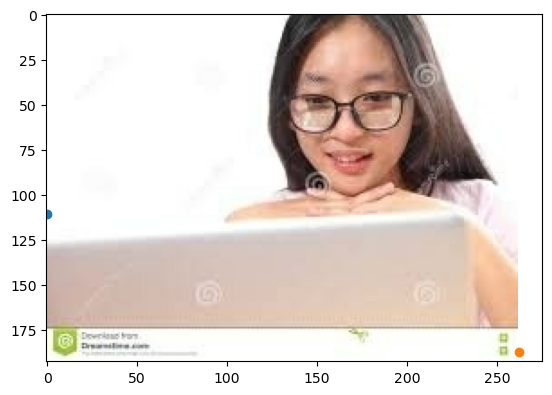

In [49]:
plt.imshow(image)
plt.scatter(detector_output['detection_boxes'][0,class_idx][1]*262, detector_output['detection_boxes'][0,class_idx][0]*193)
plt.scatter(detector_output['detection_boxes'][0,class_idx][3]*262, detector_output['detection_boxes'][0,class_idx][2]*193)
plt.show()

In [31]:
image.shape

TensorShape([193, 262, 3])

In [ ]:
1 person
2 bicycle
3 car
4 motorcycle
5 airplane
6 bus
7 train
8 truck
9 boat
10 traffic light
11 fire hydrant
13 stop sign
14 parking meter
15 bench
16 bird
17 cat
18 dog
19 horse
20 sheep
21 cow
22 elephant
23 bear
24 zebra
25 giraffe
27 backpack
28 umbrella
31 handbag
32 tie
33 suitcase
34 frisbee
35 skis
36 snowboard
37 sports ball
38 kite
39 baseball bat
40 baseball glove
41 skateboard
42 surfboard
43 tennis racket
44 bottle
46 wine glass
47 cup
48 fork
49 knife
50 spoon
51 bowl
52 banana
53 apple
54 sandwich
55 orange
56 broccoli
57 carrot
58 hot dog
59 pizza
60 donut
61 cake
62 chair
63 couch
64 potted plant
65 bed
67 dining table
70 toilet
72 tv
73 laptop
74 mouse
75 remote
76 keyboard
77 cell phone
78 microwave
79 oven
80 toaster
81 sink
82 refrigerator
84 book
85 clock
86 vase
87 scissors
88 teddy bear
89 hair drier
90 toothbrush

In [ ]:
image_path = data_directory + '/train/Image_87.jpg'
image_keypoints_category(image_path, df)

In [ ]:
# train a model to predict the category of the image based on the keypoints
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# define the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(51,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(15)
])

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# load the data
data = []

for i in range(10):
    image_path = data_directory+ '/train/' + df['filename'][i]
    data.append(image_keypoints_category(image_path, df))
    
data[:][1]


In [ ]:
# split the data into training and testing
np.random.shuffle(data)
split = int(0.8 * len(data))
train_data = data[:split]
test_data = data[split:]

# train the model
model.fit(train_data[:,0].tolist(), train_data[:,1], epochs=10)

# evaluate the model
test_loss, test_acc = model.evaluate(test_data[:,0].tolist(), test_data[:,1], verbose=2)
print('\nTest accuracy:', test_acc)